In [12]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import chart_studio

In [13]:
project= 'bigdata-273220'
dataset = 'yelp_reviews'
table = 'yelp_reviews'

In [26]:
chart_studio.tools.set_credentials_file(username='rashmisankepally', api_key='UCrXbtnNnkPxWjMyLnb2')
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')

In [1]:
#@title Install Latest Version of Some Packages
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade google-cloud-bigquery-storage
!pip install --upgrade pyarrow
!pip install --upgrade google-cloud-core

Requirement already up-to-date: google-cloud-bigquery in /opt/conda/anaconda/lib/python3.7/site-packages (1.24.0)
ERROR: pandas-profiling 2.5.0 has requirement jinja2==2.11.1, but you'll have jinja2 2.10.3 which is incompatible.
ERROR: nbclient 0.2.0 has requirement nbformat>=5.0, but you'll have nbformat 4.4.0 which is incompatible.
ERROR: jupyterlab-git 0.10.0 has requirement nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.14.0 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
     |████████████████████████████████| 143kB 3.5MB/s eta 0:00:01
     |████████████████████████████████| 64.2MB 36.6MB/s eta 0:00:01
  Found existing installation: pyarrow 0.15.1
    Uninstalling pyarrow-0.15.1:
      Successfully uninstalled pyarrow-0.15.1
Requirement already up-to-date: google-cloud-core in /opt/conda/anaconda/li

In [2]:
# Packages used for interfacing w/ BigQuery from Python
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1

# Create BigQuery client
bq_client = bigquery.Client(project = 'bigdata-273220')

# Create BigQuery storage client
bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

### Correlation Coefficient between Star Rating and Sentiment

In [30]:
import pandas as pd
query = """
SELECT compound as sentiment, stars FROM `bigdata-273220.yelp_reviews.restaurant_senti` 
where business_id="El4FC8jcawUVgw_0EIcbaQ"
"""

In [72]:
query_business1 = """
SELECT name FROM `bigdata-273220.yelp.yelp_business` WHERE business_id="El4FC8jcawUVgw_0EIcbaQ"
"""
query_business2 = """
SELECT COUNT(categories)as freq, categories FROM `bigdata-273220.yelp.yelp_business`
GROUP BY categories
ORDER BY freq DESC
LIMIT 1000
"""

In [55]:
bq_client.query(query_business1).result().to_dataframe()

,name
0,MGM Grand Hotel


In [73]:
df_categories = bq_client.query(query_business2).result().to_dataframe()

0      1055
1      1045
2      1028
3      1017
4       980
       ... 
995      17
996      17
997      17
998      17
999      17
Name: freq, Length: 1000, dtype: int64

In [74]:
traces = []

traces.append(go.Scatter(
            x=df_categories.categories,
            y=df_categories.freq,
            name="Business Categories"
        ))
py.iplot(traces, filename = "categories")

### This is the snapshot of the categories of different businesses. The top category looks like Nail salons here. But actually many categories include Restaurants (you can see my hovering on the chart) which are filtered for in my analysis.

In [31]:
df_data = bq_client.query(query).result().to_dataframe()

In [33]:
df_data.sentiment

0      -0.9846
1       0.9354
2      -0.9777
3       0.9465
4       0.9696
         ...  
4584   -0.8124
4585    0.9864
4586    0.9600
4587    0.9981
4588    0.9382
Name: sentiment, Length: 4589, dtype: float64

In [43]:
traces = []

traces.append(go.Scatter(
            x=df_data.sentiment,
            y=df_data.stars,
            mode='markers',
            name="compound vs stars"
        ))
py.iplot(traces, filename = "blue")

### Observation: This is the chart for one business. The star rating were whole number from 1-5 while the sentiment is a floating point from -0.5 to 0.5. The reviews are unsurpisingly less negative for the higher star ratings of 4 and 5. But the sentiment seems to range the whole spectrum for lesser stars - This is probably where the sentiment analyzer could not detect the sentiment correctly. 
I am not going to plot for the full dataset as I think it will give a cluttered plot that would be unreadable. 
This plot is for the MGM Grand Hotel. Also my plotly subscription is limited to 524 KB with the free version

In [37]:
df_data.corr(method='pearson')

,sentiment,stars
sentiment,1.000000,0.581457
stars,0.581457,1.000000


### Finding: Correlation Coefficient for a single chosen business is 0.58 - pretty low. I will check for the full dataset across all businesses

In [41]:
query_full = """
SELECT compound as sentiment, stars FROM `bigdata-273220.yelp_reviews.restaurant_senti`
"""
full_data = bq_client.query(query_full).result().to_dataframe()

In [42]:
full_data.corr(method='pearson')

,sentiment,stars
sentiment,1.000000,0.594901
stars,0.594901,1.000000


# Observation: 5M rows took a bit more time to run compared to 5k rows! Correlation Coefficient is close to 0.6.
### This is not surprising given the rule based VaderSentiment Analyzer and long and complicated reviews that included sarcasm.

# Now, I am going to explore factors affecting reviews based on the Nouns and Adjectives extracted from review text. 

In [75]:
!gsutil cp eg_review_senti_words.json gs://comparebusiness/yelp-dataset/eg_review_senti_words.json

Copying file://eg_review_senti_words.json [Content-Type=application/json]...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      


In [79]:
pip install wordcloud

     |████████████████████████████████| 368kB 3.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [84]:
collect_words ="""
SELECT STRING_AGG(adj) as adj_all, STRING_AGG(noun) as noun_all, business_id 
FROM `bigdata-273220.yelp_reviews.eg_senti_words` 
GROUP BY business_id
"""

In [103]:
words_df = bq_client.query(collect_words).result().to_dataframe()

In [110]:
wordcloud_nouns = WordCloud().generate(words_df.noun_all[2])

(-0.5, 399.5, 199.5, -0.5)

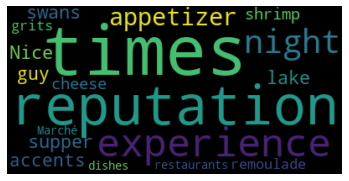

In [111]:
plt.imshow(wordcloud_nouns, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

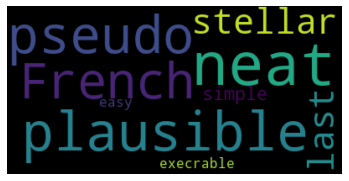

In [113]:
wordcloud_adjs = WordCloud().generate(words_df.adj_all[2])
plt.imshow(wordcloud_adjs, interpolation='bilinear')
plt.axis("off")

# I could only perform the word cloud analysis on a sample of the data (2000 reviews) because the larger file of 4.9 GB was taking too long to upload to my storage bucket(and BigQuery). Not sure what I can do better about this. But same code can be used to observe nouns and adjectives appearing in reviews for different businesses.